<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing-publication" data-toc-modified-id="Preprocessing-publication-1">Preprocessing publication</a></span><ul class="toc-item"><li><span><a href="#publication.csv-revisited" data-toc-modified-id="publication.csv-revisited-1.1"><code>publication.csv</code> revisited</a></span></li><li><span><a href="#Apply-standard-preprocessing:" data-toc-modified-id="Apply-standard-preprocessing:-1.2">Apply standard preprocessing:</a></span></li><li><span><a href="#Distribution-of-length-of-summary" data-toc-modified-id="Distribution-of-length-of-summary-1.3">Distribution of length of summary</a></span></li></ul></li><li><span><a href="#Preprocessing-scrapped-PDF" data-toc-modified-id="Preprocessing-scrapped-PDF-2">Preprocessing scrapped <code>PDF</code></a></span><ul class="toc-item"><li><span><a href="#Distribution-of-length-of-combined-summary" data-toc-modified-id="Distribution-of-length-of-combined-summary-2.1">Distribution of length of combined summary</a></span></li><li><span><a href="#Publications-from-2012-2017" data-toc-modified-id="Publications-from-2012-2017-2.2">Publications from <code>2012-2017</code></a></span><ul class="toc-item"><li><span><a href="#Check-how-many-of-these-publications-doesnt-have-pdf2txt:" data-toc-modified-id="Check-how-many-of-these-publications-doesnt-have-pdf2txt:-2.2.1">Check how many of these publications doesnt have pdf2txt:</a></span></li></ul></li></ul></li></ul></div>

# Preprocessing publication 

In this notebook, I aim to detail the methods used for preprocessing the abstract and publications that will be part of the corpus used for topic modelling further down the pipeline.

Building on the dataset from the [preprocess-poinf.ipynb](../../../infnet-scrapper/notebooks/preprocess-poinf.ipynb), we further preprocess the additional details scrapped from Edinburgh research explorer. 

The main focus of [preprocess-poinf.ipynb](../../../infnet-scrapper/notebooks/preprocess-poinf.ipynb) is to preprocess the data collected from Edinburgh Research Explorer for . This notebook, on the other hand, focuses on the publications - the abstracts (if any) and publications/conferences that the research is presented in.

<s>This is a precursor to a full-blown LDA analysis on the PDF of the research (the research papers).</s> Refer to [preprocessing pdf2txt](#Preprocessing-scrapped-PDF)

## `publication.csv` revisited

I analyse the `publication.csv` dataset in this section.

In [1]:
import pandas as pd
import re

In [2]:
pub_csv = pd.read_csv('../data/publications.csv')
print 'pub_csv contains:', len(pub_csv), ' publications'
pub_csv.iloc[40:45] # sample the data

pub_csv contains: 8810  publications


,pub_id,date,year,title,authors,pub_url,doi_url,pdf_url,abstract,publications
40,f4293dd4-09a5-420b-b37a-2bd88d45c6e6,1 Jun 2007,2007,statistical postediting on systrans rulebased ...,loïc dugast|jean senellart|philipp koehn,http://www.research.ed.ac.uk/portal/en/publica...,UNKNOWN,http://www.research.ed.ac.uk/portal/files/1936...,this article describes the combination of a sy...,proceedings of the second workshop on statisti...
41,fc393df2-bf68-45cd-85ce-9faeb2c9d9b4,17 May 2017,2017,endtoend deep learning of optimization heuristics,christopher cummins|pavlos petoumenos|zheng wa...,http://www.research.ed.ac.uk/portal/en/publica...,UNKNOWN,http://www.research.ed.ac.uk/portal/files/3774...,accurate automatic optimization heuristics are...,the 26th international conference on parallel ...
42,c7a7fc62-2251-441c-86ac-9e0a0a0d39c9,2016,2016,a list of successes that can change the world ...,sam lindley|conor mcbride|philip trinder|donal...,http://www.research.ed.ac.uk/portal/en/publica...,http://dx.doi.org/10.1007/978-3-319-30936-1,UNKNOWN,unknown,"springer international publishing,springer int..."
43,d7dbd219-5022-49c5-87d7-d6bafacfd3d8,2002,2002,a hierarchy of polynomialtime computable simul...,kousha etessami,http://www.research.ed.ac.uk/portal/en/publica...,http://dx.doi.org/10.1007/3-540-45694-5_10,UNKNOWN,we define and provide algorithms for computing...,"concur 2002 - concurrency theory,13th internat..."
44,8b81bb37-fced-4e23-a85d-ff82d715a2a0,2006,2006,computational modelling as an approach to neur...,jörg behrendt|hecke schrobsdorff|matthias ihrk...,http://www.research.ed.ac.uk/portal/en/publica...,UNKNOWN,http://www.nld.ds.mpg.de/~hecke/archiv/2006_BC...,negative priming (np),international journal of psychophysiology


In [3]:
# Focusing on the publication where 
pub_csv.set_index('pub_id',inplace=True)
pub_concise = pub_csv[['year', 'title', 'abstract', 'publications']].copy()

In [4]:
# Remove all entries that are 'UNKNOWN', so that when we combine them into the `summary` column, 
# `UNKNOWN` is not a term for consideration
def removeUnknown(x):
    if str(x).strip().lower() == 'unknown':
        return ''
    else:
        return x

In [5]:
pub_concise = pub_concise.applymap(removeUnknown)

In [6]:
# Concatenate all the text together to form as the representation of the publication:
pub_concise['summary'] = pub_concise.apply(
    lambda row: str(row.title) + '. ' + str(row.abstract) + '. '+  str(row.publications),
    axis=1)

## Apply standard preprocessing:

In [7]:
import Stemmer
import string

In [8]:
# Standard preprocessing:
# 1. tokenizer: split by word boundary.
tokenize = lambda x: [t.lower().strip() for t in re.split(r'\W+', x) if len(t) > 0]

# 2. stopping: import common stopwords
stopWordsDir = "../data/englishST.txt"
sw = open(stopWordsDir, "r").read().splitlines()
sw.extend(list(string.punctuation.decode('utf-8')))
stop = set(sw)
removeSW = lambda x: [t for t in x if t not in stop]

# 3: Stemming: using pystemmer
stemmer = Stemmer.Stemmer("english")
stem = lambda x : stemmer.stemWords(x)

In [9]:
preprocess = lambda x: stem(removeSW(tokenize(x)))

In [10]:
first = pub_concise.iloc[0].summary.decode('utf-8') + '~'

In [11]:
print " ".join(preprocess(first))

balloon stabil analysi jet hmode discharg previous studi stabil larg aspect ratio model equilibrium ideal mhd balloon mode shown bulk plasma exist margin stabl valu pressur gradient paramet defin unstabl zone separ small stabl region larg stabl region close separatrix region coalesc surfac averag current densiti exceed critic plasma region stabl balloon mode valu pressur gradient paper extend result jet mode equilibria finit aspect ratio balloon formal assess relev ideal balloon stabil discharg analys shot 15894 time 56 sec 1 3 phase proceed 16th european confer control fusion plasma physic


In [12]:
pub_concise['summary_toks'] = pub_concise.apply(
    lambda row: preprocess(row.summary.decode('utf8')), axis=1)

In [13]:
pub_concise.head(4)

,year,title,abstract,publications,summary,summary_toks
pub_id,,,,,,
400818dc-63af-4a26-80c5-906f98e1f8ab,1989,ballooning stability analysis of jet hmode dis...,previous studies of the stability of a large a...,proceedings 16th european conference on contr...,ballooning stability analysis of jet hmode dis...,"[balloon, stabil, analysi, jet, hmode, dischar..."
18b1a861-afef-4fff-bc80-d02e05be18c4,2013,query processing in data integration,in this chapter we illustrate the main techniq...,"data exchange, integration, and streams,dagstu...",query processing in data integration in this c...,"[queri, process, data, integr, chapter, illust..."
309fdbfc-227b-4588-9264-f0f4e3cadfcb,1994,comprehension syntax,the syntax of comprehensions is very close to ...,sigmod record,comprehension syntax the syntax of comprehensi...,"[comprehens, syntax, syntax, comprehens, close..."
d5814bab-5fc2-4c31-92b7-543c7ce75cb4,2012,evaluation of speaker verification security an...,"in this paper, we evaluate the vulnerability o...","ieee transactions on audio, speech and languag...",evaluation of speaker verification security an...,"[evalu, speaker, verif, secur, detect, hmmbase..."


## Distribution of length of summary

In [17]:
pub_toks = pub_concise[['summary_toks']].copy()

In [18]:
pub_toks.head(2)

,summary_toks
pub_id,
400818dc-63af-4a26-80c5-906f98e1f8ab,"[balloon, stabil, analysi, jet, hmode, dischar..."
18b1a861-afef-4fff-bc80-d02e05be18c4,"[queri, process, data, integr, chapter, illust..."


In [19]:
# inspect and check if there is any publication with no `summary_toks`
for row in pub_toks.iterrows():
    if len(row[1]['summary_toks']) == 0:
        print row[0]

In [20]:
# get a distribution of length of tokens:
toksLengthHist = {}
for row in pub_toks.iterrows():
    l = len(row[1]['summary_toks'])
    if l not in toksLengthHist.keys():
        toksLengthHist[l] = 1
    else:
        toksLengthHist[l] += 1

In [21]:
lengthHist = [(v,k) for (v,k) in toksLengthHist.iteritems()]

In [22]:
print lengthHist

[(1, 1), (2, 4), (3, 14), (4, 26), (5, 55), (6, 62), (7, 83), (8, 105), (9, 84), (10, 98), (11, 97), (12, 88), (13, 83), (14, 57), (15, 66), (16, 58), (17, 51), (18, 44), (19, 44), (20, 40), (21, 41), (22, 41), (23, 34), (24, 38), (25, 33), (26, 35), (27, 27), (28, 36), (29, 29), (30, 38), (31, 33), (32, 24), (33, 38), (34, 38), (35, 30), (36, 33), (37, 30), (38, 38), (39, 42), (40, 53), (41, 39), (42, 49), (43, 40), (44, 44), (45, 36), (46, 42), (47, 55), (48, 61), (49, 68), (50, 77), (51, 71), (52, 60), (53, 52), (54, 70), (55, 69), (56, 79), (57, 76), (58, 78), (59, 81), (60, 73), (61, 79), (62, 72), (63, 84), (64, 76), (65, 89), (66, 73), (67, 90), (68, 77), (69, 84), (70, 83), (71, 104), (72, 100), (73, 85), (74, 82), (75, 91), (76, 109), (77, 84), (78, 91), (79, 106), (80, 89), (81, 92), (82, 105), (83, 89), (84, 89), (85, 84), (86, 85), (87, 93), (88, 85), (89, 83), (90, 90), (91, 83), (92, 66), (93, 77), (94, 82), (95, 83), (96, 76), (97, 80), (98, 80), (99, 70), (100, 81), (10

In [20]:
# Visualise:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
lengths = zip(*lengthHist)[0]
freq = zip(*lengthHist)[1]

In [25]:
import numpy as np

In [26]:
data = [list(lengths), list(freq)]
pd_data = pd.DataFrame(np.array(data).T, columns=['length','count'])

In [27]:
pd_data.head(5)

,length,count
0,1,1
1,2,4
2,3,14
3,4,26
4,5,55


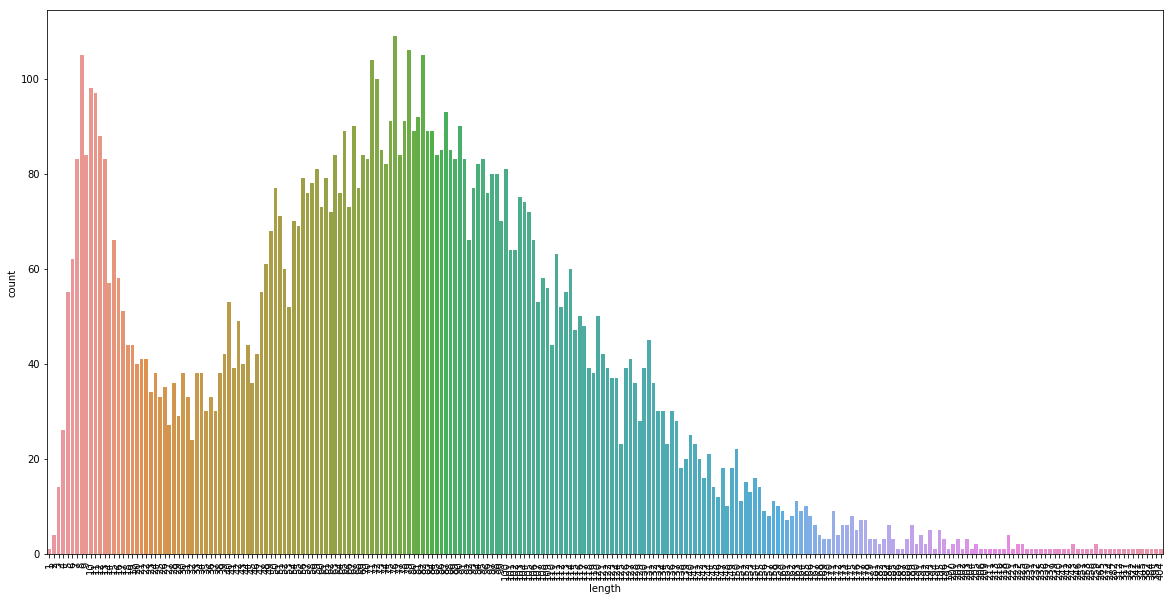

In [34]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
sns.barplot(x='length', y='count', data=pd_data, ax=ax)
plt.xticks(rotation=90);
# plt.savefig('./IMG/distribution_of_pub_length.pdf', format='pdf', bbox_inches='tight')

In [35]:
pub_concise.to_pickle('../data/pub_toks.pkl')

----

# Preprocessing scrapped `PDF`

In this section, we pre-process all the pdf that we seen in the Edinburgh Research Explorer. Some publications may not have any `pdf` (that is converted to txt (see infnet-scrapper/notebooks))

In [14]:
import os

In [38]:
collection = {}
txtdir = '../../infnet-scrapper/data/pdf2txt/txt/'
for txt in os.listdir(txtdir):
    txt_id = txt.split(".txt")[0]
    pdf = open(txtdir + txt)
    _txt = " ".join(pdf.readlines())
    if len(_txt) >= 1:
        collection[str(txt_id)] = str(_txt)
    else:
        print(txt_id)
    pdf.close()

03b5ea65-0e55-4ca1-bcd9-124484ae9b65
04edfd3c-35ee-44d7-a2ea-11ed5d7f7d1a
07ddf95b-5d2d-42f7-ae9e-cfdb914dae6d
0b45b3e8-a6c4-40a3-a108-942ec9ba85f7
0ec3bdbf-5de6-4607-aba9-862cadf626a4
20e71cdb-5e4d-4513-a3b8-7d416e35aeb4
2e98e3d6-0892-49fb-984e-d000a9505975
40cbb66f-1c5c-46f6-b9a3-d9fa59254aad
41899314-b749-41a4-b47e-521d4bd9b16a
45e72a8e-99a9-4e99-8b99-c02b01bb7008
48877653-39f8-4f4c-8bf2-80d2af6d0be7
53ff0dc9-6438-43d8-ac4b-40b699cb6bd8
61d43d74-2d5a-4caf-a063-edbe2a178cb8
6df05941-cac1-4822-9618-0953abbf8150
7557595b-8082-4278-90e4-d7fc4fbf3b86
75ab99bb-f99d-404a-82ac-121186506851
85900df7-dfcd-459c-af18-3f82254e0d70
8ce362b8-8c40-4760-9dc1-d8b5cc3622ed
996f454b-d2ac-4bc8-9779-ca158eedcdda
9d1702f3-63fb-49a1-85b2-6f6b5edcaa43
a1b50efd-61dd-4734-8493-983a07621321
a4caa3e2-b3ba-4bf9-abb0-1a79228c4721
a80888fe-96e5-4fee-ab1b-1457404e28ea
a95c419b-d44d-4ae6-892e-0a089f4d3476
b88208d0-709e-4237-a036-cc45dc53aa75
be1c98b3-010d-4e25-bcc0-6b1f7910eabb
befdc0f0-f710-4775-bc29-dd5a095b8459
c

In [39]:
len(collection)

2553

In [40]:
collection['fc393df2-bf68-45cd-85ce-9faeb2c9d9b4']

'PACT Submission #47\xe2\x80\x93 Con\xef\xac\x81dential Draft \xe2\x80\x93 Do Not Distribute!!\n \n End-to-end Deep Learning of Optimization Heuristics\n \n Abstract\n \n Accurate automatic optimization heuristics are necessary\n for dealing with the complexity and diversity of modern hard-\n ware and software. Machine learning is a proven technique\n for learning such heuristics, but its success is bound by the\n quality of the features used. These features must be hand\n crafted by developers through a combination of expert domain\n knowledge and trial and error. This makes the quality of the\n \xef\xac\x81nal model directly dependent on the skill and available time\n of the system architect.\n \n Our work introduces a better way for building heuristics.\n We develop a deep neural network that learns heuristics over\n raw code, entirely without using code features. The neural net-\n work simultaneously constructs appropriate representations\n of the code and learns how best to optimi

In [73]:
pdf2txt = pd.Series(collection).to_frame()
pdf2txt.rename(columns = {0:'pdf2txt'},inplace=True)

In [74]:
pdf2txt.head(3)

,pdf2txt
00297304-61a7-4bb4-a89a-347a57f02778,Transferring CNNs to Multi-instance Multi-labe...
0089d717-9642-4970-a51d-d32b69bed24b,Multiagent Systems for Social Computation\n \n...
009a3bb6-15a1-4c0a-85c9-5df51cd3438e,A Linked Data Approach to Know-How\n Citation ...


In [79]:
pub_csv_combined = pub_csv.join(pdf2txt, how='left')

TypeError: join() got an unexpected keyword argument 'validate'

In [76]:
pub_csv_combined.head(3)

,date,year,title,authors,pub_url,doi_url,pdf_url,abstract,publications,pdf2txt
pub_id,,,,,,,,,,
400818dc-63af-4a26-80c5-906f98e1f8ab,1989,1989,ballooning stability analysis of jet hmode dis...,d.p. o'brien|r. galvao|m. keilhacker|e. lazzar...,http://www.research.ed.ac.uk/portal/en/publica...,UNKNOWN,UNKNOWN,previous studies of the stability of a large a...,proceedings 16th european conference on contr...,NaN
18b1a861-afef-4fff-bc80-d02e05be18c4,2013,2013,query processing in data integration,paolo guagliardo|piotr wieczorek,http://www.research.ed.ac.uk/portal/en/publica...,UNKNOWN,UNKNOWN,in this chapter we illustrate the main techniq...,"data exchange, integration, and streams,dagstu...",NaN
309fdbfc-227b-4588-9264-f0f4e3cadfcb,Mar 1994,1994,comprehension syntax,p. buneman|l. libkin|d. suciu|v. tannen|l. wong,http://www.research.ed.ac.uk/portal/en/publica...,http://dx.doi.org/10.1145/181550.181564,http://www.research.ed.ac.uk/portal/files/1651...,the syntax of comprehensions is very close to ...,sigmod record,Comprehension Syntax\n \n Citation for publish...


In [80]:
pub_csv_combined_concise = pub_csv_combined[['year', 'title', 'abstract', 'publications', 'pdf2txt']].copy()
pub_csv_combined_concise.fillna(value='',axis=1,inplace=True)

In [87]:
# Concatenate all the text together to form as the representation of the publication:
pub_csv_combined_concise['combined'] = pub_csv_combined_concise.apply(
    lambda row: str(row.title) + '. ' + str(row.abstract) + '. '+  str(row.publications) + '. ' + str(row.pdf2txt),
    axis=1)

In [100]:
pub_csv_combined_concise['toks'] = pub_csv_combined_concise.apply(
    lambda row: preprocess(row.combined.decode('utf8')), axis=1)

In [102]:
pub_csv_combined_concise.head(3)

,year,title,abstract,publications,pdf2txt,combined,toks
pub_id,,,,,,,
400818dc-63af-4a26-80c5-906f98e1f8ab,1989,ballooning stability analysis of jet hmode dis...,previous studies of the stability of a large a...,proceedings 16th european conference on contr...,,ballooning stability analysis of jet hmode dis...,"[balloon, stabil, analysi, jet, hmode, dischar..."
18b1a861-afef-4fff-bc80-d02e05be18c4,2013,query processing in data integration,in this chapter we illustrate the main techniq...,"data exchange, integration, and streams,dagstu...",,query processing in data integration. in this ...,"[queri, process, data, integr, chapter, illust..."
309fdbfc-227b-4588-9264-f0f4e3cadfcb,1994,comprehension syntax,the syntax of comprehensions is very close to ...,sigmod record,Comprehension Syntax\n \n Citation for publish...,comprehension syntax. the syntax of comprehens...,"[comprehens, syntax, syntax, comprehens, close..."


In [114]:
pub_csv_combined_concise.to_pickle('../data/pub_toks_w_pdf2txt.pkl')

## Distribution of length of combined summary

In [103]:
pub_toks = pub_csv_combined_concise[['toks']].copy()

In [105]:
# inspect and check if there is any publication with no `summary_toks`
for row in pub_toks.iterrows():
    if len(row[1]['toks']) == 0:
        print row[0]

In [106]:
# get a distribution of length of tokens:
toksLengthHist = {}
for row in pub_toks.iterrows():
    l = len(row[1]['toks'])
    if l not in toksLengthHist.keys():
        toksLengthHist[l] = 1
    else:
        toksLengthHist[l] += 1

In [107]:
lengthHist = [(v,k) for (v,k) in toksLengthHist.iteritems()]

In [111]:
lengths = zip(*lengthHist)[0]
freq = zip(*lengthHist)[1]

In [112]:
data = [list(lengths), list(freq)]
pd_data = pd.DataFrame(np.array(data).T, columns=['length', 'count'])

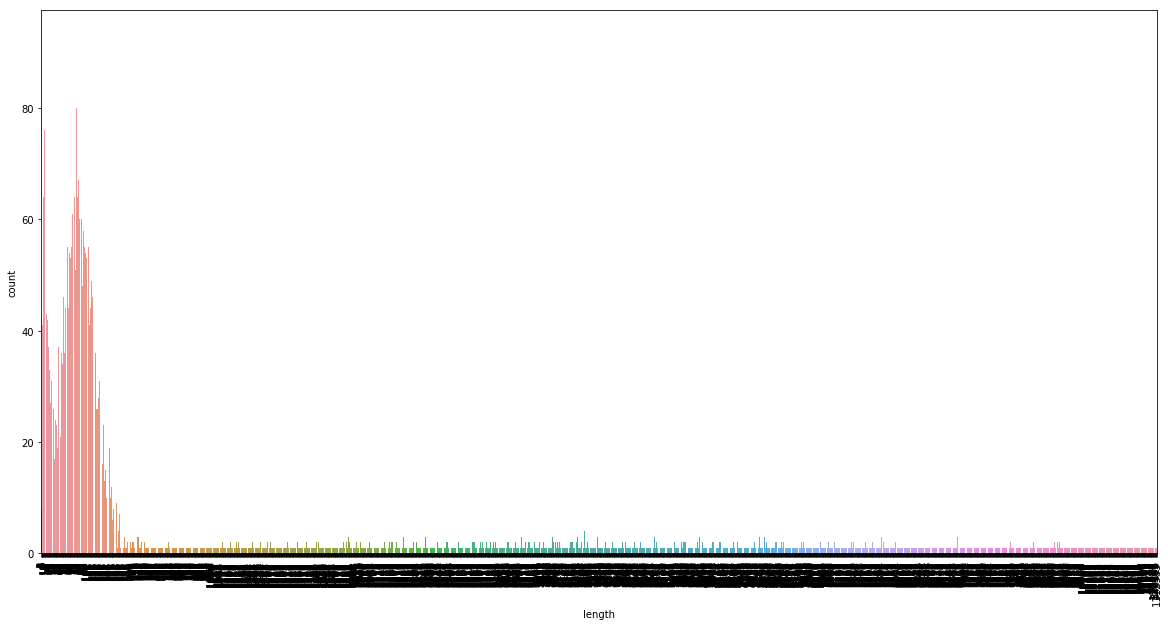

In [113]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
sns.barplot(x='length', y='count', data=pd_data, ax=ax)
plt.xticks(rotation=90)
# plt.savefig('./IMG/distribution_of_pub_length.pdf', format='pdf', bbox_inches='tight')

## Publications from `2012-2017`

In [2]:
pub_all = pd.read_pickle('../data/pub_toks_w_pdf2txt.pkl')

In [4]:
pub_all.head(3)

,year,title,abstract,publications,pdf2txt,combined,toks
pub_id,,,,,,,
400818dc-63af-4a26-80c5-906f98e1f8ab,1989,ballooning stability analysis of jet hmode dis...,previous studies of the stability of a large a...,proceedings 16th european conference on contr...,,ballooning stability analysis of jet hmode dis...,"[balloon, stabil, analysi, jet, hmode, dischar..."
18b1a861-afef-4fff-bc80-d02e05be18c4,2013,query processing in data integration,in this chapter we illustrate the main techniq...,"data exchange, integration, and streams,dagstu...",,query processing in data integration. in this ...,"[queri, process, data, integr, chapter, illust..."
309fdbfc-227b-4588-9264-f0f4e3cadfcb,1994,comprehension syntax,the syntax of comprehensions is very close to ...,sigmod record,Comprehension Syntax\n \n Citation for publish...,comprehension syntax. the syntax of comprehens...,"[comprehens, syntax, syntax, comprehens, close..."


In [5]:
gb = pub_all.groupby('year')

In [6]:
sixYears = ['2017', '2016', '2015', '2014', '2013', '2012']
pd_years = {}
print("Year:\tPub count")
for yr, group in gb:
    if yr in sixYears:
        pd_years[yr] = group
        print("{}:\t{}".format(yr, len(group)))

Year:	Pub count
2012:	573
2013:	623
2014:	629
2015:	583
2016:	645
2017:	521


In [7]:
pub_combined_yrs = pd.concat(pd_years.values())

In [44]:
# Save the 2012-2017:
pub_combined_yrs.to_pickle('../data/pub_toks_w_pdf2txt_2012-17.pkl')

### Check how many of these publications doesnt have pdf2txt:

In [37]:
print('{}\t{}\t{}'.format('Year:','Pub count', '#pdf2txt'))
for yr, df in pd_years.items():
      _pdf2txts = df.pdf2txt.values
      count = len([len(a.strip()) for a in _pdf2txts if len(a) > 0])
      print('{}\t{}\t\t{}'.format(yr, len(df), count))
    

Year:	Pub count	#pdf2txt
2015	583		236
2014	629		235
2017	521		253
2016	645		313
2013	623		169
2012	573		143


In [17]:
len(pub_combined_yrs)

3574

Total of <b>1,349</b> publications, out of 3574, from 2012-2017 have pdf that can be converted to txt

In [38]:
pdf2txts = pub_combined_yrs.pdf2txt.values

In [39]:
num = 0
for t in pdf2txts:
    if len(t.strip()) == 0:
        num+=1

2225


In [40]:
lenhist = [len(t.strip()) for t in pdf2txts]

In [41]:
max(lenhist)

998916

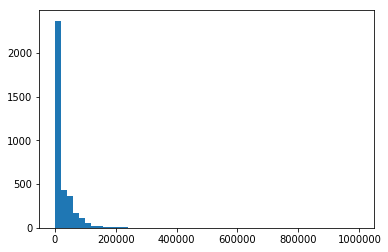

In [43]:
plt.hist(lenhist, 50);